In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from nltk.tokenize import word_tokenize

#For Stemming text
from nltk.stem import PorterStemmer        

import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob

# Convert a collection of text documents to a matrix of token counts.
from sklearn.feature_extraction.text import CountVectorizer

#To split data into train and test
from sklearn.model_selection import train_test_split

#For fitting model
from sklearn.linear_model import LogisticRegression

#For evaluation of model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt_tab')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Data collection

In [43]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("michiard/sentiment-analysis-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sentiment-analysis-dataset


In [47]:
print(os.listdir(path))

df = pd.read_csv(path+'/train.csv')

print(df.head())

['sample_submission.csv', 'train.csv', 'test.csv']
       textID                                               text  \
0  28ac06f416                        good luck with your auction   
1  92098cf9a7  Hmm..You can`t judge a book by looking at its ...   
2  7858ff28f2   Hello, yourself. Enjoy London. Watch out for ...   
3  b0c9c67f32         We can`t even call you from belgium  sucks   
4  7b36e9e7a5                                 not so good mood..   

                                       selected_text sentiment  
0                        good luck with your auction  positive  
1  Hmm..You can`t judge a book by looking at its ...   neutral  
2                                    They`re mental.  negative  
3                                            m  suck  negative  
4                                 not so good mood..  negative  


In [6]:
print(df.info())
print("Columns: " + df.columns)
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24732 entries, 0 to 24731
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         24732 non-null  object
 1   text           24732 non-null  object
 2   selected_text  24732 non-null  object
 3   sentiment      24732 non-null  object
dtypes: object(4)
memory usage: 773.0+ KB
None
Index(['Columns: textID', 'Columns: text', 'Columns: selected_text',
       'Columns: sentiment'],
      dtype='object')
(24732, 4)


In [7]:
df.describe(include='all')

,textID,text,selected_text,sentiment
count,24732,24732,24732,24732
unique,24732,24732,20298,3
top,28ac06f416,good luck with your auction,love,neutral
freq,1,1,174,10018


In [8]:
df['sentiment'].value_counts()

sentiment
neutral     10018
positive     7711
negative     7003
Name: count, dtype: int64

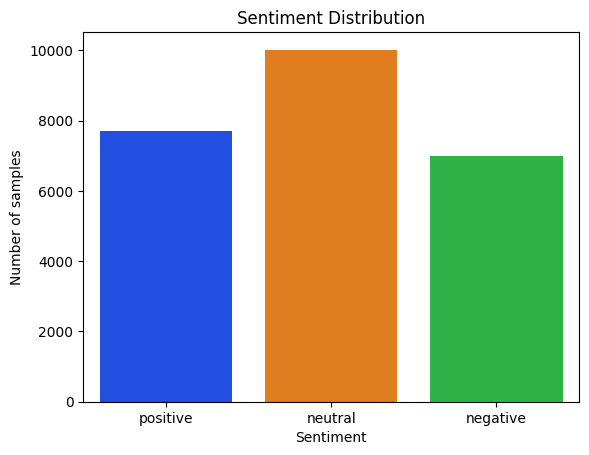

In [20]:
# Plot
sns.countplot(x='sentiment', data=df, palette='bright')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of samples')
plt.show()

# Preprocessing

## Text cleansing

In [30]:
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string


# Carica modello spaCy
nlp = spacy.load("en_core_web_sm")

# Stopwords personalizzate (manteniamo le negazioni)
stop_words = set(stopwords.words('english'))
negations = {'no', 'not', 'nor'}
stop_words = stop_words.difference(negations)

def preprocess_text(text):
    # Rimuove punteggiatura
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenizzazione
    tokens = word_tokenize(text.lower())
    
    # Lemmatizzazione con spaCy (sul testo completamente lowercase)
    doc = nlp(" ".join(tokens).lower())
    lemmatized_tokens = [token.lemma_.lower() for token in doc]

    
    # Rimozione stopwords
    final_tokens = [token for token in lemmatized_tokens if token not in stop_words and token.strip()]
    
    return final_tokens

df['removed_stop_words'] = df['text'].apply(lambda x: preprocess_text(x))

In [36]:
!pip install spacy nltk num2words
!python -m nltk.downloader punkt stopwords
!python -m spacy download en_core_web_sm


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 3.4 MB/s eta 0:00:00a 0:00:01
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=c4b3c1ea2e8315a48eea763e78b934b18b79688e6629761683b098825f69be63
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 65.1 MB/s eta 0:00:00:00:01:01
✔ Download and installation successful
You can now load th

In [48]:
import re
import string
import unicodedata
import nltk
import spacy
from nltk.corpus import stopwords
from num2words import num2words

# Downloads if needed
nltk.download('stopwords')

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Custom stopwords keeping negations
stop_words = set(stopwords.words('english'))
negations = {'no', 'not', 'nor'}
stop_words = stop_words.difference(negations)

def preprocess_text(text):
    # 1. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 2. Remove mentions and hashtags
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    
    # 3. Remove accented characters
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8', 'ignore')
    
    # 4. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 5. Convert numbers to words
    def replace_numbers(match):
        return num2words(match.group())
    text = re.sub(r'\b\d+\b', replace_numbers, text)
    
    # 6. Lowercase
    text = text.lower()
    
    # 7. Lemmatize and tokenize with spaCy
    doc = nlp(text)
    
    # 8. Remove stopwords and non-alpha tokens
    tokens = [
        token.lemma_.lower()
        for token in doc
        if token.lemma_.lower() not in stop_words and token.lemma_.isalpha()
    ]
    
    return tokens


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
df['removed_stop_words'] = df['text'].apply(lambda x: preprocess_text(x))

In [50]:
df.sample(10)

,textID,text,selected_text,sentiment,removed_stop_words
17604,da2244caf1,Ugh 2 days whatever to somewhere,Ugh 2 days whatever to somewhere,neutral,"[ugh, two, day, whatever, somewhere]"
19290,f65fc1ef7e,inFamous on the PS3 = AWESOME. My eyes are so ...,AWESOME.,positive,"[infamous, awesome, eye, sore, though]"
10626,879db8b4b6,a headache once again ugh,ugh,negative,"[headache, ugh]"
18617,9d245b189e,Sorry I`ll make sure to bomb in talk at SSUG...,Sorry,negative,"[sorry, ill, make, sure, bomb, talk, ssug, nex..."
10653,701af313d0,Happy Mother`s Day! http://tinyurl.com/re74xc,Happy Mother`s Day!,positive,"[happy, mother, day]"
2519,b5b2ced221,Maaaan... it is way too nice outside to be in ...,nice,positive,"[maaaan, way, nice, outside, work]"
15815,2b6a838592,looking for models for beauty shoot THIS THURS...,looking for models for beauty shoot THIS THURS...,neutral,"[look, model, beauty, shoot, thursday, valley,..."
20213,3163cf50c0,soooo fed up with this,soooo fed up,negative,"[soooo, feed]"
22830,088df93e03,31 degree centigrade is much hotter than 30 de...,much hotter,negative,"[thirty, one, degree, centigrade, much, hot, t..."
5968,ae45f85ae2,"Aw, Kaelah I feel so bad for you. This sounds...","Aw, Kaelah I feel so bad for you. This sounds ...",neutral,"[aw, kaelah, feel, bad, sound, serious, please..."


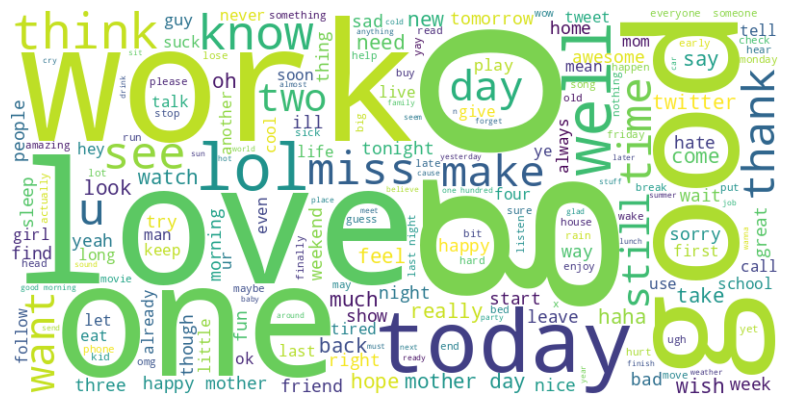

In [52]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all tokens lists into one big string
all_words = ' '.join([' '.join(tokens) for tokens in df['removed_stop_words']])

# Create and generate a word cloud image
wc = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Display the generated image:
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


In [54]:
sia = SentimentIntensityAnalyzer()
def get_sentiment_scores(text):
    scores = sia.polarity_scores(text)
    # scores example: {'neg': 0.0, 'neu': 0.453, 'pos': 0.547, 'compound': 0.5719}

    # Determine polarity
    if scores['compound'] >= 0.05:
        polarity = 'positive'
    elif scores['compound'] <= -0.05:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    # Intensity can be the absolute value of compound score
    intensity = abs(scores['compound'])

    return polarity, intensity, scores

df[['polarity', 'intensity', 'sentiment_scores']] = df['text'].apply(
    lambda x: pd.Series(get_sentiment_scores(x))
)


In [55]:
df.head()

,textID,text,selected_text,sentiment,removed_stop_words,polarity,intensity,sentiment_scores
0,28ac06f416,good luck with your auction,good luck with your auction,positive,"[good, luck, auction]",positive,0.7096,"{'neg': 0.0, 'neu': 0.337, 'pos': 0.663, 'comp..."
1,92098cf9a7,Hmm..You can`t judge a book by looking at its ...,Hmm..You can`t judge a book by looking at its ...,neutral,"[hmmyou, not, judge, book, look, cover]",neutral,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,7858ff28f2,"Hello, yourself. Enjoy London. Watch out for ...",They`re mental.,negative,"[hello, enjoy, london, watch, hackney, mental]",positive,0.4939,"{'neg': 0.0, 'neu': 0.758, 'pos': 0.242, 'comp..."
3,b0c9c67f32,We can`t even call you from belgium sucks,m suck,negative,"[not, even, call, belgium, suck]",negative,0.3612,"{'neg': 0.263, 'neu': 0.737, 'pos': 0.0, 'comp..."
4,7b36e9e7a5,not so good mood..,not so good mood..,negative,"[not, good, mood]",negative,0.3865,"{'neg': 0.466, 'neu': 0.534, 'pos': 0.0, 'comp..."
